In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import torch
from datetime import datetime, timezone
import logging
import copy

logging.basicConfig(
    level=logging.INFO,  # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format for the log messages
    handlers=[
        logging.StreamHandler()  # Log to the console
    ]
)

%reload_ext autoreload
%autoreload 2
from data.raw.retrievers.alpaca_markets_retriever import AlpacaMarketsRetriever
from data.raw.retrievers.stooq_retriever import StooqRetriever

from config.constants import *
from data.processed.dataset_creation import DatasetCreator
from data.processed.indicators import *
from data.processed.targets import Balanced3ClassClassification
from data.processed.normalization import ZScoreOverWindowNormalizer, ZScoreNormalizer, MinMaxNormalizer
from data.processed.dataset_pytorch import DatasetPytorch
from modeling.trainer import Trainer
from modeling.evaluate import evaluate_lgb_regressor, evaluate_torch_regressor, evaluate_torch_regressor_multiasset
# from observability.mlflow_integration import log_experiment

from modeling.rl.environment import PortfolioEnvironment
from modeling.rl.state import State
from modeling.rl.agent import RlAgent
from modeling.rl.algorithms.policy_gradient import PolicyGradient
from modeling.rl.actors.actor import RlActor, FullyConnectedBackend, TransformerBackend
from modeling.rl.actors.signal_predictor_actor import SignalPredictorActor
from modeling.rl.actors.high_energy_low_friction_actor import HighEnergyLowFrictionActor
from modeling.rl.actors.xsmom_actor import XSMomActor
from modeling.rl.actors.tsmom_actor import TSMomActor
from modeling.rl.actors.blsw_actor import BLSWActor
from modeling.rl.trajectory_dataset import TrajectoryDataset
from modeling.rl.metrics import MetricsCalculator, DEFAULT_METRICS
from modeling.rl.reward import EstimatedReturnReward
from modeling.rl.loss import SumLogReturnLoss
from modeling.rl.visualization.wealth_plot import plot_cumulative_wealth
from modeling.rl.visualization.position_plot import plot_position_heatmap
from config.experiments.cur_experiment import config

torch.backends.cudnn.benchmark = config.train_config.cudnn_benchmark

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
str(config.data_config.frequency)

'1Day'

In [3]:
retriever = StooqRetriever(download_from_gdrive=False)
initial_state = config.model_config.model.state_dict()

In [ ]:
def evaluate_signal_predictor(start_date: datetime, end_date: datetime, train_set_last_date: datetime, model=None):
    print(f'Running experiment for {start_date} to {end_date} with train set last date {train_set_last_date}')
    
    retrieval_result = retriever.bars(start=start_date, end=end_date)

    dataset_creator = DatasetCreator(
        features=config.data_config.features,
        target=config.data_config.target,
        normalizer=config.data_config.normalizer,
        missing_values_handler=config.data_config.missing_values_handler,
        train_set_last_date=train_set_last_date, 
        cutoff_time=config.data_config.cutoff_time,
        in_seq_len=config.data_config.in_seq_len,
        multi_asset_prediction=config.data_config.multi_asset_prediction,
    )

    X_train, y_train, next_return_train, spread_train, volatility_train, X_test, y_test, next_return_test, spread_test, volatility_test = dataset_creator.create_dataset_numpy(retrieval_result)

    print(X_train.shape, y_train.shape, next_return_train.shape, spread_train.shape, volatility_train.shape, X_test.shape, y_test.shape, next_return_test.shape, spread_test.shape, volatility_test.shape)
    print(np.sqrt(((y_train - np.ones_like(y_train) * 0.5)**2).mean()))
    print(np.sqrt(((y_test - np.ones_like(y_test) * 0.5)**2).mean()))

    if not model: 
        print('Training model...')
        train_loader = DatasetPytorch(X_train, y_train, learning_task='regression').as_dataloader(
            batch_size=config.train_config.batch_size,
            shuffle=config.train_config.shuffle,
            num_workers=config.train_config.num_workers,
            prefetch_factor=config.train_config.prefetch_factor,
            pin_memory=config.train_config.pin_memory,
            persistent_workers=config.train_config.persistent_workers,
            drop_last=config.train_config.drop_last
        )
        test_loader = DatasetPytorch(X_test, y_test, learning_task='regression').as_dataloader(
            batch_size=config.train_config.batch_size,
            shuffle=config.train_config.shuffle,
            num_workers=config.train_config.num_workers,
            prefetch_factor=config.train_config.prefetch_factor,
            pin_memory=config.train_config.pin_memory,
            persistent_workers=config.train_config.persistent_workers,
            drop_last=config.train_config.drop_last
        )

        model = config.model_config.model
        model.load_state_dict(initial_state)

        trainer = Trainer(
            model=model,
            train_loader=train_loader,
            val_loader=test_loader,
            loss_fn=config.train_config.loss_fn,
            optimizer=config.train_config.optimizer,
            scheduler=config.train_config.scheduler,
            num_epochs=config.train_config.num_epochs,
            device=config.train_config.device,
            metrics=config.train_config.metrics,
            save_path=config.train_config.save_path,
            early_stopping_patience=config.train_config.early_stopping_patience,
        )

        model, history = trainer.train()
    else: 
        print('Using existing model...')

    val_trajectory_loader = TrajectoryDataset(X_test, next_return_test, spread_test, volatility_test, trajectory_length=20).as_dataloader(
        batch_size=8, 
        shuffle=False,
        num_workers=8,
        prefetch_factor=4,
        pin_memory=True,
        persistent_workers=True,
        drop_last=True,
    )

    env = PortfolioEnvironment(
        reward_function=EstimatedReturnReward(fee=0.001, spread_multiplier=0.0),
    )

    backend = FullyConnectedBackend(
        n_assets=len(config.data_config.symbol_or_symbols),
        hidden_dim=128,
        num_layers=2, 
        dropout=0.1,
        use_layer_norm=False,
    )

    actor = RlActor(
        copy.deepcopy(model), 
        backend,
        n_assets=len(config.data_config.symbol_or_symbols),
        train_signal_predictor=False, 
        exploration_eps=0.0
    ).to(device)

    signal_predictor_actor = SignalPredictorActor(
        copy.deepcopy(model), 
        trade_asset_count=1,
        train_signal_predictor=False
    ).to(device)

    rl_agent = RlAgent(
        actor, 
        env,
        single_action_per_trajectory=True
    )

    metrics_calculator = MetricsCalculator(
        metrics=DEFAULT_METRICS
    )

    policy_gradient = PolicyGradient(
        rl_agent, 
        None, 
        val_trajectory_loader, 
        metrics_calculator=metrics_calculator,
        optimizer=torch.optim.AdamW(
            [p for p in actor.parameters() if p.requires_grad], 
            lr=1e-3,
            weight_decay=1e-5,
            amsgrad=True),
        scheduler=None,
        loss_fn=SumLogReturnLoss(use_baseline=False),
        num_epochs=10,
        device=device
    )

    epoch_loss, realized_returns_signal_predictor, actions_signal_predictor = policy_gradient.evaluate(signal_predictor_actor)
    return realized_returns_signal_predictor, model


In [ ]:
start_end_last_train_dates = [
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2008, 9, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2007, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2006, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2009, 9, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2008, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2007, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2010, 9, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2009, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2008, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2011, 9, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2010, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2009, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2012, 9, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2011, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2010, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2013, 9, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2012, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2011, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2014, 9, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2013, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2012, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2015, 9, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2014, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2013, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2016, 9, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2015, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2014, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2017, 9, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2016, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2015, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2018, 9, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2017, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2016, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2019, 9, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2018, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2017, 9, 1, tzinfo=timezone.utc)},
]

In [ ]:
realized_returns = []
for i in range(len(start_end_last_train_dates)):
    best_model = None
    best_mean_return = 0
    for j in range(5): 
        cur_rezlized_returns, model = evaluate_signal_predictor(
            start_end_last_train_dates[i]['start'], 
            start_end_last_train_dates[i]['last_val_date'], 
            start_end_last_train_dates[i]['last_train_date'])
        if np.mean(cur_rezlized_returns) > best_mean_return:
            best_mean_return = np.mean(cur_rezlized_returns)
            best_model = model

    realized_returns.extend(
        evaluate_signal_predictor(
            start_end_last_train_dates[i]['start'], 
            start_end_last_train_dates[i]['end'], 
            start_end_last_train_dates[i]['last_val_date'], 
            best_model)[0])

2025-08-18 18:37:04,966 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:37:05,024 - INFO - trv_us_d.csv has no data prior to 1999-06-01


Running experiment for 1999-06-01 00:00:00+00:00 to 2008-09-01 00:00:00+00:00 with train set last date 2007-09-01 00:00:00+00:00


2025-08-18 18:37:06,359 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:37:06,760 - INFO - Processing WMT …
2025-08-18 18:37:06,783 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:37:06,784 - INFO - Spread has 0 NaNs
2025-08-18 18:37:06,786 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:37:06,789 - INFO - Processing VZ …
2025-08-18 18:37:06,811 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:37:06,811 - INFO - Spread has 0 NaNs
2025-08-18 18:37:06,814 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:37:06,816 - INFO - Processing UNH …
2025-08-18 18:37:06,838 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:37:06,838 - INFO - Spread has 0 NaNs
2025-08-18 18:37:06,841 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:37:06,843 - INFO - Processing SHW …
2025-08-18 18:37:06,865 - WARN

(2008, 27, 60, 15) (2008, 27) (2008, 27) (2008, 27) (2008, 27) (250, 27, 60, 15) (250, 27) (250, 27) (250, 27) (250, 27)
0.35246432
0.38145676


2025-08-18 18:37:07,948 - INFO - Epoch 1/20
2025-08-18 18:37:09,470 - INFO - Train Loss: 0.3233      
2025-08-18 18:37:09,470 - INFO - Train Rmse: 0.5672
2025-08-18 18:37:09,470 - INFO - Val   Loss: 0.1517
2025-08-18 18:37:09,470 - INFO - Val   Rmse: 0.3895
2025-08-18 18:37:09,471 - INFO - 
2025-08-18 18:37:09,472 - INFO - Epoch 2/20
2025-08-18 18:37:10,103 - INFO - Train Loss: 0.1839      
2025-08-18 18:37:10,103 - INFO - Train Rmse: 0.4279
2025-08-18 18:37:10,103 - INFO - Val   Loss: 0.1444
2025-08-18 18:37:10,103 - INFO - Val   Rmse: 0.3799
2025-08-18 18:37:10,104 - INFO - 
2025-08-18 18:37:10,105 - INFO - Epoch 3/20
2025-08-18 18:37:10,735 - INFO - Train Loss: 0.1530      
2025-08-18 18:37:10,736 - INFO - Train Rmse: 0.3903
2025-08-18 18:37:10,736 - INFO - Val   Loss: 0.1634
2025-08-18 18:37:10,736 - INFO - Val   Rmse: 0.4042
2025-08-18 18:37:10,736 - INFO - 
2025-08-18 18:37:10,736 - INFO - Epoch 4/20
2025-08-18 18:37:11,364 - INFO - Train Loss: 0.1429      
2025-08-18 18:37:11,36

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0104
Running experiment for 1999-06-01 00:00:00+00:00 to 2009-09-01 00:00:00+00:00 with train set last date 2008-09-01 00:00:00+00:00


2025-08-18 18:37:21,965 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:37:22,015 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:37:23,014 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:37:23,325 - INFO - Processing WMT …
2025-08-18 18:37:23,348 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:37:23,349 - INFO - Spread has 0 NaNs
2025-08-18 18:37:23,351 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:37:23,354 - INFO - Processing VZ …
2025-08-18 18:37:23,376 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:37:23,377 - INFO - Spread has 0 NaNs
2025-08-18 18:37:23,379 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:37:23,381 - INFO - Processing UNH …
2025-08-18 18:37:23,404 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:37:23,405 - INFO - Spread has 0 NaNs
2025

(2259, 27, 60, 15) (2259, 27) (2259, 27) (2259, 27) (2259, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.35304147
0.4143027


2025-08-18 18:37:25,421 - INFO - Train Loss: 0.2919      
2025-08-18 18:37:25,421 - INFO - Train Rmse: 0.5364
2025-08-18 18:37:25,421 - INFO - Val   Loss: 0.1871
2025-08-18 18:37:25,422 - INFO - Val   Rmse: 0.4325
2025-08-18 18:37:25,422 - INFO - 
2025-08-18 18:37:25,423 - INFO - Epoch 2/20
2025-08-18 18:37:26,130 - INFO - Train Loss: 0.1582      
2025-08-18 18:37:26,130 - INFO - Train Rmse: 0.3972
2025-08-18 18:37:26,131 - INFO - Val   Loss: 0.1939
2025-08-18 18:37:26,131 - INFO - Val   Rmse: 0.4400
2025-08-18 18:37:26,131 - INFO - 
2025-08-18 18:37:26,132 - INFO - Epoch 3/20
2025-08-18 18:37:26,853 - INFO - Train Loss: 0.1380      
2025-08-18 18:37:26,853 - INFO - Train Rmse: 0.3712
2025-08-18 18:37:26,853 - INFO - Val   Loss: 0.1813
2025-08-18 18:37:26,853 - INFO - Val   Rmse: 0.4258
2025-08-18 18:37:26,854 - INFO - 
2025-08-18 18:37:26,855 - INFO - Epoch 4/20
2025-08-18 18:37:27,565 - INFO - Train Loss: 0.1417      
2025-08-18 18:37:27,565 - INFO - Train Rmse: 0.3760
2025-08-18 18:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0209
Running experiment for 1999-06-01 00:00:00+00:00 to 2010-09-01 00:00:00+00:00 with train set last date 2009-09-01 00:00:00+00:00


2025-08-18 18:37:37,229 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:37:38,316 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:37:38,621 - INFO - Processing WMT …
2025-08-18 18:37:38,644 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:37:38,645 - INFO - Spread has 0 NaNs
2025-08-18 18:37:38,648 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:37:38,650 - INFO - Processing VZ …
2025-08-18 18:37:38,673 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:37:38,673 - INFO - Spread has 0 NaNs
2025-08-18 18:37:38,676 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:37:38,678 - INFO - Processing UNH …
2025-08-18 18:37:38,701 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:37:38,702 - INFO - Spread has 0 NaNs
2025-08-18 18:37:38,704 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
20

(2511, 27, 60, 15) (2511, 27) (2511, 27) (2511, 27) (2511, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.35271934
0.3405185


2025-08-18 18:37:40,812 - INFO - Train Loss: 0.2878      
2025-08-18 18:37:40,812 - INFO - Train Rmse: 0.5325
2025-08-18 18:37:40,812 - INFO - Val   Loss: 0.1143
2025-08-18 18:37:40,812 - INFO - Val   Rmse: 0.3377
2025-08-18 18:37:40,813 - INFO - 
2025-08-18 18:37:40,814 - INFO - Epoch 2/20
2025-08-18 18:37:41,607 - INFO - Train Loss: 0.1516      
2025-08-18 18:37:41,607 - INFO - Train Rmse: 0.3888
2025-08-18 18:37:41,608 - INFO - Val   Loss: 0.1199
2025-08-18 18:37:41,608 - INFO - Val   Rmse: 0.3462
2025-08-18 18:37:41,608 - INFO - 
2025-08-18 18:37:41,608 - INFO - Epoch 3/20
2025-08-18 18:37:42,417 - INFO - Train Loss: 0.1311      
2025-08-18 18:37:42,418 - INFO - Train Rmse: 0.3619
2025-08-18 18:37:42,418 - INFO - Val   Loss: 0.1125
2025-08-18 18:37:42,418 - INFO - Val   Rmse: 0.3352
2025-08-18 18:37:42,418 - INFO - 
2025-08-18 18:37:42,419 - INFO - Epoch 4/20
2025-08-18 18:37:43,208 - INFO - Train Loss: 0.1335      
2025-08-18 18:37:43,209 - INFO - Train Rmse: 0.3652
2025-08-18 18:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0689
Running experiment for 1999-06-01 00:00:00+00:00 to 2011-09-01 00:00:00+00:00 with train set last date 2010-09-01 00:00:00+00:00


2025-08-18 18:37:53,200 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:37:53,255 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:37:54,277 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:37:54,581 - INFO - Processing WMT …
2025-08-18 18:37:54,606 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:37:54,606 - INFO - Spread has 0 NaNs
2025-08-18 18:37:54,609 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:37:54,611 - INFO - Processing VZ …
2025-08-18 18:37:54,635 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:37:54,636 - INFO - Spread has 0 NaNs
2025-08-18 18:37:54,638 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:37:54,641 - INFO - Processing UNH …
2025-08-18 18:37:54,665 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:37:54,665 - INFO - Spread has 0 NaNs
2025

(2763, 27, 60, 15) (2763, 27) (2763, 27) (2763, 27) (2763, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.3529047
0.329731


2025-08-18 18:37:56,933 - INFO - Train Loss: 0.2765      
2025-08-18 18:37:56,933 - INFO - Train Rmse: 0.5209
2025-08-18 18:37:56,934 - INFO - Val   Loss: 0.1110
2025-08-18 18:37:56,934 - INFO - Val   Rmse: 0.3331
2025-08-18 18:37:56,934 - INFO - 
2025-08-18 18:37:56,935 - INFO - Epoch 2/20
2025-08-18 18:37:57,797 - INFO - Train Loss: 0.1560      
2025-08-18 18:37:57,797 - INFO - Train Rmse: 0.3945
2025-08-18 18:37:57,797 - INFO - Val   Loss: 0.1292
2025-08-18 18:37:57,797 - INFO - Val   Rmse: 0.3593
2025-08-18 18:37:57,798 - INFO - 
2025-08-18 18:37:57,798 - INFO - Epoch 3/20
2025-08-18 18:37:58,649 - INFO - Train Loss: 0.1380      
2025-08-18 18:37:58,650 - INFO - Train Rmse: 0.3712
2025-08-18 18:37:58,650 - INFO - Val   Loss: 0.1077
2025-08-18 18:37:58,650 - INFO - Val   Rmse: 0.3282
2025-08-18 18:37:58,650 - INFO - 
2025-08-18 18:37:58,651 - INFO - Epoch 4/20
2025-08-18 18:37:59,500 - INFO - Train Loss: 0.1328      
2025-08-18 18:37:59,500 - INFO - Train Rmse: 0.3642
2025-08-18 18:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0058
Running experiment for 1999-06-01 00:00:00+00:00 to 2012-09-01 00:00:00+00:00 with train set last date 2011-09-01 00:00:00+00:00


2025-08-18 18:38:13,700 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:38:13,752 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:38:14,774 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:38:15,082 - INFO - Processing WMT …
2025-08-18 18:38:15,107 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:38:15,108 - INFO - Spread has 0 NaNs
2025-08-18 18:38:15,111 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:38:15,113 - INFO - Processing VZ …
2025-08-18 18:38:15,138 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:38:15,138 - INFO - Spread has 0 NaNs
2025-08-18 18:38:15,141 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:38:15,143 - INFO - Processing UNH …
2025-08-18 18:38:15,168 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:38:15,168 - INFO - Spread has 0 NaNs
2025

(3015, 27, 60, 15) (3015, 27) (3015, 27) (3015, 27) (3015, 27) (252, 27, 60, 15) (252, 27) (252, 27) (252, 27) (252, 27)
0.35291982
0.33650115


2025-08-18 18:38:17,556 - INFO - Train Loss: 0.2582      
2025-08-18 18:38:17,556 - INFO - Train Rmse: 0.5033
2025-08-18 18:38:17,557 - INFO - Val   Loss: 0.1075
2025-08-18 18:38:17,557 - INFO - Val   Rmse: 0.3279
2025-08-18 18:38:17,557 - INFO - 
2025-08-18 18:38:17,559 - INFO - Epoch 2/20
2025-08-18 18:38:18,492 - INFO - Train Loss: 0.1499      
2025-08-18 18:38:18,492 - INFO - Train Rmse: 0.3869
2025-08-18 18:38:18,492 - INFO - Val   Loss: 0.1026
2025-08-18 18:38:18,493 - INFO - Val   Rmse: 0.3203
2025-08-18 18:38:18,493 - INFO - 
2025-08-18 18:38:18,494 - INFO - Epoch 3/20
2025-08-18 18:38:19,425 - INFO - Train Loss: 0.1367      
2025-08-18 18:38:19,426 - INFO - Train Rmse: 0.3694
2025-08-18 18:38:19,426 - INFO - Val   Loss: 0.1483
2025-08-18 18:38:19,426 - INFO - Val   Rmse: 0.3850
2025-08-18 18:38:19,426 - INFO - 
2025-08-18 18:38:19,427 - INFO - Epoch 4/20
2025-08-18 18:38:20,358 - INFO - Train Loss: 0.1314      
2025-08-18 18:38:20,358 - INFO - Train Rmse: 0.3623
2025-08-18 18:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0796
Running experiment for 1999-06-01 00:00:00+00:00 to 2013-09-01 00:00:00+00:00 with train set last date 2012-09-01 00:00:00+00:00


2025-08-18 18:38:28,296 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:38:28,347 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:38:29,399 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:38:29,711 - INFO - Processing WMT …
2025-08-18 18:38:29,738 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:38:29,739 - INFO - Spread has 0 NaNs
2025-08-18 18:38:29,742 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:38:29,744 - INFO - Processing VZ …
2025-08-18 18:38:29,770 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:38:29,771 - INFO - Spread has 0 NaNs
2025-08-18 18:38:29,773 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:38:29,776 - INFO - Processing UNH …
2025-08-18 18:38:29,801 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:38:29,802 - INFO - Spread has 0 NaNs
2025

(3268, 27, 60, 15) (3268, 27) (3268, 27) (3268, 27) (3268, 27) (248, 27, 60, 15) (248, 27) (248, 27) (248, 27) (248, 27)
0.35257334
0.3268152


2025-08-18 18:38:32,410 - INFO - Train Loss: 0.2617      
2025-08-18 18:38:32,410 - INFO - Train Rmse: 0.5061
2025-08-18 18:38:32,410 - INFO - Val   Loss: 0.1060
2025-08-18 18:38:32,411 - INFO - Val   Rmse: 0.3254
2025-08-18 18:38:32,411 - INFO - 
2025-08-18 18:38:32,412 - INFO - Epoch 2/20
2025-08-18 18:38:33,429 - INFO - Train Loss: 0.1434      
2025-08-18 18:38:33,429 - INFO - Train Rmse: 0.3784
2025-08-18 18:38:33,429 - INFO - Val   Loss: 0.1021
2025-08-18 18:38:33,429 - INFO - Val   Rmse: 0.3194
2025-08-18 18:38:33,429 - INFO - 
2025-08-18 18:38:33,431 - INFO - Epoch 3/20
2025-08-18 18:38:34,451 - INFO - Train Loss: 0.1290      
2025-08-18 18:38:34,451 - INFO - Train Rmse: 0.3591
2025-08-18 18:38:34,451 - INFO - Val   Loss: 0.1070
2025-08-18 18:38:34,452 - INFO - Val   Rmse: 0.3270
2025-08-18 18:38:34,452 - INFO - 
2025-08-18 18:38:34,452 - INFO - Epoch 4/20
2025-08-18 18:38:35,468 - INFO - Train Loss: 0.1280      
2025-08-18 18:38:35,468 - INFO - Train Rmse: 0.3577
2025-08-18 18:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0070
Running experiment for 1999-06-01 00:00:00+00:00 to 2014-09-01 00:00:00+00:00 with train set last date 2013-09-01 00:00:00+00:00


2025-08-18 18:38:51,267 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:38:51,321 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:38:52,442 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:38:52,755 - INFO - Processing WMT …
2025-08-18 18:38:52,782 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:38:52,783 - INFO - Spread has 0 NaNs
2025-08-18 18:38:52,786 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:38:52,788 - INFO - Processing VZ …
2025-08-18 18:38:52,814 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:38:52,815 - INFO - Spread has 0 NaNs
2025-08-18 18:38:52,818 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:38:52,820 - INFO - Processing UNH …
2025-08-18 18:38:52,846 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:38:52,847 - INFO - Spread has 0 NaNs
2025

(3517, 27, 60, 15) (3517, 27) (3517, 27) (3517, 27) (3517, 27) (250, 27, 60, 15) (250, 27) (250, 27) (250, 27) (250, 27)
0.35263535
0.2995212


2025-08-18 18:38:55,430 - INFO - Train Loss: 0.2482      
2025-08-18 18:38:55,431 - INFO - Train Rmse: 0.4920
2025-08-18 18:38:55,431 - INFO - Val   Loss: 0.0842
2025-08-18 18:38:55,431 - INFO - Val   Rmse: 0.2900
2025-08-18 18:38:55,431 - INFO - 
2025-08-18 18:38:55,433 - INFO - Epoch 2/20
2025-08-18 18:38:56,501 - INFO - Train Loss: 0.1407      
2025-08-18 18:38:56,501 - INFO - Train Rmse: 0.3749
2025-08-18 18:38:56,501 - INFO - Val   Loss: 0.0860
2025-08-18 18:38:56,501 - INFO - Val   Rmse: 0.2932
2025-08-18 18:38:56,501 - INFO - 
2025-08-18 18:38:56,502 - INFO - Epoch 3/20
2025-08-18 18:38:57,570 - INFO - Train Loss: 0.1378      
2025-08-18 18:38:57,571 - INFO - Train Rmse: 0.3708
2025-08-18 18:38:57,571 - INFO - Val   Loss: 0.0924
2025-08-18 18:38:57,571 - INFO - Val   Rmse: 0.3038
2025-08-18 18:38:57,571 - INFO - 
2025-08-18 18:38:57,572 - INFO - Epoch 4/20
2025-08-18 18:38:58,645 - INFO - Train Loss: 0.1297      
2025-08-18 18:38:58,645 - INFO - Train Rmse: 0.3599
2025-08-18 18:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0167
Running experiment for 1999-06-01 00:00:00+00:00 to 2015-09-01 00:00:00+00:00 with train set last date 2014-09-01 00:00:00+00:00


2025-08-18 18:39:09,913 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:39:10,911 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:39:11,220 - INFO - Processing WMT …
2025-08-18 18:39:11,247 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:39:11,248 - INFO - Spread has 0 NaNs
2025-08-18 18:39:11,251 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:39:11,253 - INFO - Processing VZ …
2025-08-18 18:39:11,280 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:39:11,280 - INFO - Spread has 0 NaNs
2025-08-18 18:39:11,284 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:39:11,286 - INFO - Processing UNH …
2025-08-18 18:39:11,313 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:39:11,313 - INFO - Spread has 0 NaNs
2025-08-18 18:39:11,316 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
20

(3768, 27, 60, 15) (3768, 27) (3768, 27) (3768, 27) (3768, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.352518
0.3193879


2025-08-18 18:39:14,062 - INFO - Train Loss: 0.2438      
2025-08-18 18:39:14,062 - INFO - Train Rmse: 0.4880
2025-08-18 18:39:14,062 - INFO - Val   Loss: 0.0991
2025-08-18 18:39:14,063 - INFO - Val   Rmse: 0.3143
2025-08-18 18:39:14,063 - INFO - 
2025-08-18 18:39:14,064 - INFO - Epoch 2/20
2025-08-18 18:39:15,214 - INFO - Train Loss: 0.1432      
2025-08-18 18:39:15,214 - INFO - Train Rmse: 0.3781
2025-08-18 18:39:15,214 - INFO - Val   Loss: 0.1004
2025-08-18 18:39:15,215 - INFO - Val   Rmse: 0.3168
2025-08-18 18:39:15,215 - INFO - 
2025-08-18 18:39:15,215 - INFO - Epoch 3/20
2025-08-18 18:39:16,358 - INFO - Train Loss: 0.1317      
2025-08-18 18:39:16,358 - INFO - Train Rmse: 0.3628
2025-08-18 18:39:16,359 - INFO - Val   Loss: 0.0993
2025-08-18 18:39:16,359 - INFO - Val   Rmse: 0.3150
2025-08-18 18:39:16,359 - INFO - 
2025-08-18 18:39:16,359 - INFO - Epoch 4/20
2025-08-18 18:39:17,516 - INFO - Train Loss: 0.1326      
2025-08-18 18:39:17,516 - INFO - Train Rmse: 0.3639
2025-08-18 18:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0093
Running experiment for 1999-06-01 00:00:00+00:00 to 2016-09-01 00:00:00+00:00 with train set last date 2015-09-01 00:00:00+00:00


2025-08-18 18:39:36,587 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:39:36,637 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:39:37,677 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:39:37,985 - INFO - Processing WMT …
2025-08-18 18:39:38,014 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:39:38,015 - INFO - Spread has 0 NaNs
2025-08-18 18:39:38,018 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:39:38,020 - INFO - Processing VZ …
2025-08-18 18:39:38,048 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:39:38,049 - INFO - Spread has 0 NaNs
2025-08-18 18:39:38,052 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:39:38,055 - INFO - Processing UNH …
2025-08-18 18:39:38,082 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:39:38,083 - INFO - Spread has 0 NaNs
2025

(4020, 27, 60, 15) (4020, 27) (4020, 27) (4020, 27) (4020, 27) (252, 27, 60, 15) (252, 27) (252, 27) (252, 27) (252, 27)
0.3531582
0.34785655


2025-08-18 18:39:41,021 - INFO - Train Loss: 0.2482      
2025-08-18 18:39:41,022 - INFO - Train Rmse: 0.4925
2025-08-18 18:39:41,022 - INFO - Val   Loss: 0.1156
2025-08-18 18:39:41,022 - INFO - Val   Rmse: 0.3398
2025-08-18 18:39:41,022 - INFO - 
2025-08-18 18:39:41,024 - INFO - Epoch 2/20
2025-08-18 18:39:42,251 - INFO - Train Loss: 0.1442      
2025-08-18 18:39:42,251 - INFO - Train Rmse: 0.3795
2025-08-18 18:39:42,252 - INFO - Val   Loss: 0.1182
2025-08-18 18:39:42,252 - INFO - Val   Rmse: 0.3438
2025-08-18 18:39:42,252 - INFO - 
2025-08-18 18:39:42,253 - INFO - Epoch 3/20
2025-08-18 18:39:43,477 - INFO - Train Loss: 0.1295      
2025-08-18 18:39:43,477 - INFO - Train Rmse: 0.3598
2025-08-18 18:39:43,477 - INFO - Val   Loss: 0.1207
2025-08-18 18:39:43,477 - INFO - Val   Rmse: 0.3475
2025-08-18 18:39:43,478 - INFO - 
2025-08-18 18:39:43,478 - INFO - Epoch 4/20
2025-08-18 18:39:44,702 - INFO - Train Loss: 0.1296      
2025-08-18 18:39:44,703 - INFO - Train Rmse: 0.3598
2025-08-18 18:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0034
Running experiment for 1999-06-01 00:00:00+00:00 to 2017-09-01 00:00:00+00:00 with train set last date 2016-09-01 00:00:00+00:00


2025-08-18 18:40:03,594 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:40:03,759 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:40:04,744 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:40:05,051 - INFO - Processing WMT …
2025-08-18 18:40:05,080 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:40:05,081 - INFO - Spread has 0 NaNs
2025-08-18 18:40:05,084 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:40:05,087 - INFO - Processing VZ …
2025-08-18 18:40:05,115 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:40:05,116 - INFO - Spread has 0 NaNs
2025-08-18 18:40:05,119 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:40:05,122 - INFO - Processing UNH …
2025-08-18 18:40:05,150 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:40:05,151 - INFO - Spread has 0 NaNs
2025

(4273, 27, 60, 15) (4273, 27) (4273, 27) (4273, 27) (4273, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.35259905
0.31802788


2025-08-18 18:40:08,238 - INFO - Train Loss: 0.2413      
2025-08-18 18:40:08,238 - INFO - Train Rmse: 0.4854
2025-08-18 18:40:08,238 - INFO - Val   Loss: 0.1146
2025-08-18 18:40:08,239 - INFO - Val   Rmse: 0.3384
2025-08-18 18:40:08,239 - INFO - 
2025-08-18 18:40:08,241 - INFO - Epoch 2/20
2025-08-18 18:40:09,547 - INFO - Train Loss: 0.1398      
2025-08-18 18:40:09,547 - INFO - Train Rmse: 0.3736
2025-08-18 18:40:09,547 - INFO - Val   Loss: 0.1323
2025-08-18 18:40:09,548 - INFO - Val   Rmse: 0.3635
2025-08-18 18:40:09,548 - INFO - 
2025-08-18 18:40:09,548 - INFO - Epoch 3/20
2025-08-18 18:40:10,868 - INFO - Train Loss: 0.1293      
2025-08-18 18:40:10,869 - INFO - Train Rmse: 0.3595
2025-08-18 18:40:10,869 - INFO - Val   Loss: 0.0945
2025-08-18 18:40:10,869 - INFO - Val   Rmse: 0.3074
2025-08-18 18:40:10,869 - INFO - 
2025-08-18 18:40:10,870 - INFO - Epoch 4/20
2025-08-18 18:40:12,172 - INFO - Train Loss: 0.1308      
2025-08-18 18:40:12,172 - INFO - Train Rmse: 0.3614
2025-08-18 18:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0213
Running experiment for 1999-06-01 00:00:00+00:00 to 2018-09-01 00:00:00+00:00 with train set last date 2017-09-01 00:00:00+00:00


2025-08-18 18:40:24,430 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:40:24,481 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:40:25,574 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:40:25,883 - INFO - Processing WMT …
2025-08-18 18:40:25,913 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:40:25,914 - INFO - Spread has 0 NaNs
2025-08-18 18:40:25,917 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:40:25,920 - INFO - Processing VZ …
2025-08-18 18:40:25,949 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:40:25,949 - INFO - Spread has 0 NaNs
2025-08-18 18:40:25,953 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:40:25,955 - INFO - Processing UNH …
2025-08-18 18:40:25,984 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:40:25,984 - INFO - Spread has 0 NaNs
2025

(4525, 27, 60, 15) (4525, 27) (4525, 27) (4525, 27) (4525, 27) (251, 27, 60, 15) (251, 27) (251, 27) (251, 27) (251, 27)
0.3526218
0.33797672


2025-08-18 18:40:29,159 - INFO - Train Loss: 0.2327      
2025-08-18 18:40:29,160 - INFO - Train Rmse: 0.4770
2025-08-18 18:40:29,160 - INFO - Val   Loss: 0.1134
2025-08-18 18:40:29,160 - INFO - Val   Rmse: 0.3365
2025-08-18 18:40:29,160 - INFO - 
2025-08-18 18:40:29,162 - INFO - Epoch 2/20
2025-08-18 18:40:30,532 - INFO - Train Loss: 0.1439      
2025-08-18 18:40:30,532 - INFO - Train Rmse: 0.3790
2025-08-18 18:40:30,532 - INFO - Val   Loss: 0.1722
2025-08-18 18:40:30,532 - INFO - Val   Rmse: 0.4150
2025-08-18 18:40:30,533 - INFO - 
2025-08-18 18:40:30,533 - INFO - Epoch 3/20
2025-08-18 18:40:31,897 - INFO - Train Loss: 0.1335      
2025-08-18 18:40:31,897 - INFO - Train Rmse: 0.3649
2025-08-18 18:40:31,897 - INFO - Val   Loss: 0.1109
2025-08-18 18:40:31,898 - INFO - Val   Rmse: 0.3331
2025-08-18 18:40:31,898 - INFO - 
2025-08-18 18:40:31,899 - INFO - Epoch 4/20
2025-08-18 18:40:33,260 - INFO - Train Loss: 0.1285      
2025-08-18 18:40:33,260 - INFO - Train Rmse: 0.3583
2025-08-18 18:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0084
Running experiment for 1999-06-01 00:00:00+00:00 to 2019-09-01 00:00:00+00:00 with train set last date 2018-09-01 00:00:00+00:00


2025-08-18 18:40:46,193 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:40:46,244 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:40:47,228 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-18 18:40:47,535 - INFO - Processing WMT …
2025-08-18 18:40:47,565 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:40:47,566 - INFO - Spread has 0 NaNs
2025-08-18 18:40:47,570 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:40:47,572 - INFO - Processing VZ …
2025-08-18 18:40:47,601 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:40:47,602 - INFO - Spread has 0 NaNs
2025-08-18 18:40:47,606 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 18:40:47,608 - INFO - Processing UNH …
2025-08-18 18:40:47,638 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 18:40:47,639 - INFO - Spread has 0 NaNs
2025

(4777, 27, 60, 15) (4777, 27) (4777, 27) (4777, 27) (4777, 27) (249, 27, 60, 15) (249, 27) (249, 27) (249, 27) (249, 27)
0.35265657
0.37119082


2025-08-18 18:40:51,005 - INFO - Train Loss: 0.2300      
2025-08-18 18:40:51,005 - INFO - Train Rmse: 0.4736
2025-08-18 18:40:51,006 - INFO - Val   Loss: 0.1419
2025-08-18 18:40:51,006 - INFO - Val   Rmse: 0.3767
2025-08-18 18:40:51,006 - INFO - 
2025-08-18 18:40:51,008 - INFO - Epoch 2/20
2025-08-18 18:40:52,472 - INFO - Train Loss: 0.1373      
2025-08-18 18:40:52,472 - INFO - Train Rmse: 0.3703
2025-08-18 18:40:52,472 - INFO - Val   Loss: 0.1376
2025-08-18 18:40:52,472 - INFO - Val   Rmse: 0.3708
2025-08-18 18:40:52,473 - INFO - 
2025-08-18 18:40:52,474 - INFO - Epoch 3/20
2025-08-18 18:40:53,944 - INFO - Train Loss: 0.1317      
2025-08-18 18:40:53,944 - INFO - Train Rmse: 0.3628
2025-08-18 18:40:53,944 - INFO - Val   Loss: 0.1351
2025-08-18 18:40:53,944 - INFO - Val   Rmse: 0.3673
2025-08-18 18:40:53,945 - INFO - 
2025-08-18 18:40:53,946 - INFO - Epoch 4/20
2025-08-18 18:40:55,403 - INFO - Train Loss: 0.1304      
2025-08-18 18:40:55,403 - INFO - Train Rmse: 0.3610
2025-08-18 18:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0017


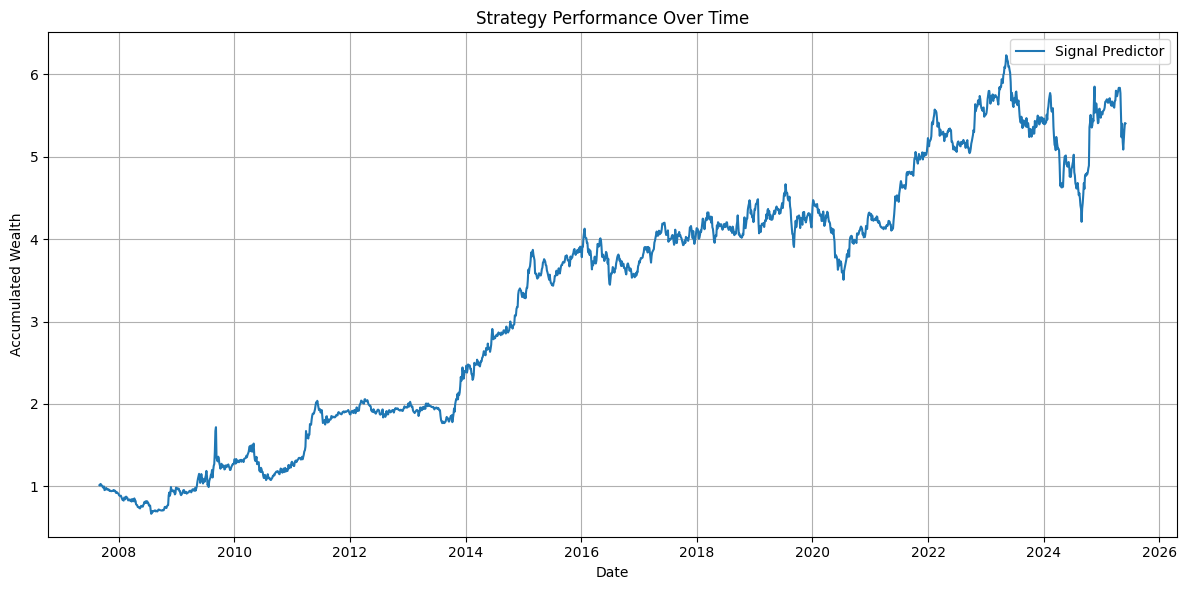

In [7]:
plot_cumulative_wealth(
    returns_dict={
        'Signal Predictor': realized_returns,
    }, 
    start_time=config.data_config.train_set_last_date, 
    end_time=config.data_config.end
)

In [9]:
realized_returns_attention_no_embed = realized_returns
pd.Series(realized_returns_attention_no_embed).to_csv('realized_returns_attention_embed.csv')